In [1]:
import os
import pandas as pd 
import numpy as np

import tensorflow 
from tensorflow import keras
from keras import layers, regularizers

import cv2 #images
import psycopg2


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## import dependencies for model
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.metrics import classification_report, confusion_matrix

2024-10-22 20:44:48.360268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Database connection setup

import json

with open('config.json', 'r') as config_file:
    config = json.load(config_file)

DB_HOST = config["DB_HOST"]
DB_NAME = config["DB_NAME"]
DB_USER = config["DB_USER"]
DB_PASS = config["DB_PASS"]


In [3]:
# import pandas as pd
# import psycopg2
# from PIL import Image
# import io
# import base64

# # Connect to the database
# connection = psycopg2.connect(
#             host=DB_HOST,
#             database=DB_NAME,
#             user=DB_USER,
#             password=DB_PASS
# )

# cursor = connection.cursor()

# # Read the metadata CSV
# metadata = pd.read_csv('/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Dataset/HAM10000_metadata.csv')

# # Function to convert image to binary data
# def image_to_binary(image_path):
#     with open(image_path, 'rb') as file:
#         binary_data = file.read()
#     return binary_data

# # Base paths for the image directories
# image_dir_1 = '/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Dataset/HAM10000_images_part_1'
# image_dir_2 = '/Users/Jack/Desktop/Skin-Cancer-Detection-Project-4/Dataset/HAM10000_images_part_2'

# # Insert the data into the table
# for index, row in metadata.iterrows():
#     image_id = row['image_id']
    
#     # Check which directory contains the image
#     image_path_1 = os.path.join(image_dir_1, f"{image_id}.jpg")
#     image_path_2 = os.path.join(image_dir_2, f"{image_id}.jpg")
    
#     if os.path.exists(image_path_1):
#         image_path = image_path_1
#     elif os.path.exists(image_path_2):
#         image_path = image_path_2
#     else:
#         print(f"Image {image_id} not found in either directory.")
#         continue

#     try:
#         binary_data = image_to_binary(image_path)
#         cursor.execute(
#             """
#             INSERT INTO skin_cancer_data (lesion_id, image_id, dx, dx_type, age, sex, localization, image_data)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
#             """,
#             (row['lesion_id'], row['image_id'], row['dx'], row['dx_type'],
#              row['age'], row['sex'], row['localization'], psycopg2.Binary(binary_data))
#         )
#     except Exception as e:
#         print(f"Error processing image {image_id}: {e}")

# # Commit the transaction and close the connection
# connection.commit()
# cursor.close()
# connection.close()


In [4]:
import pandas as pd
import json
from sqlalchemy import create_engine

# Load database connection parameters from config.json
def load_config():
    with open('config.json', 'r') as file:
        config = json.load(file)
    return config

# Create a SQLAlchemy engine using parameters from config
def create_engine_connection():
    config = load_config()
    DB_USER = config["DB_USER"]
    DB_PASS = config["DB_PASS"]
    DB_HOST = config["DB_HOST"]
    DB_NAME = config["DB_NAME"]
    
    engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}')
    return engine

# Function to load data from the database using SQLAlchemy engine
def load_data_from_db():
    engine = create_engine_connection()
    query = "SELECT * FROM skin_cancer_data;"
    df = pd.read_sql(query, engine)
    engine.dispose()  # Properly dispose of the engine when done
    return df

# Load the data and display the head of the DataFrame
df = load_data_from_db()
print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_data  
0  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  
1  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  
2  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  
3  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  
4  [b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ...  


In [5]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_data
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[b'\xff', b'\xd8', b'\xff', b'\xdb', b'\x00', ..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   image_data    10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [7]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [15]:
from PIL import Image
import io
import numpy as np

def process_images_in_batches(df, batch_size=20):
    total_images = len(df)
    batch = df.iloc[:batch_size]
   
    new_df = pd.DataFrame()  
    new_df['image_id'] = batch['image_id']
    new_df['image_array'] = None
    
    for idx, row in batch.iterrows():
        binary_data = row['image_data']
        with Image.open(io.BytesIO(binary_data)) as im: 
            image = im.resize((224, 224))
            image_array = np.array(image) / 255.0
            new_df['image_array'].iloc[idx]= image_array
            
    return new_df


In [18]:
# Call the function with your DataFrame
X_images = process_images_in_batches(df)
X_images.head()

/var/folders/w1/kv9m74sx7rn3jh6fkm7wrzrc0000gp/T/ipykernel_42856/2838277830.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  new_df['image_array'].iloc[idx]= image_array
/var/folders/w1/kv9m74sx7rn3jh6fkm7wrzrc0000gp/T/ipykernel_42856/28

,image_id,image_array
0,ISIC_0027419,"[[[0.7333333333333333, 0.5882352941176471, 0.7..."
1,ISIC_0025030,"[[[0.09411764705882353, 0.050980392156862744, ..."
2,ISIC_0026769,"[[[0.7294117647058823, 0.4980392156862745, 0.5..."
3,ISIC_0025661,"[[[0.09019607843137255, 0.043137254901960784, ..."
4,ISIC_0031633,"[[[0.49019607843137253, 0.3254901960784314, 0...."


In [19]:
# Save the DataFrame as a CSV file
X_images.to_csv('skin_cancer_detection_array.csv', index=False)

In [ ]:
# from PIL import Image
# import io
# import numpy as np

# def process_images(df):
#     images = []
#     for binary_data in df['image_data']:
#         # Open the binary data as an image
#         image = Image.open(io.BytesIO(binary_data))
#         # Resize the image to 224x224
#         image = image.resize((224, 224))
#         # Convert the image to a numpy array and normalize pixel values
#         image_array = np.array(image) / 255.0
#         images.append(image_array)
#     return np.array(images)


In [ ]:
# from PIL import Image
# import io

# # Convert image binary data back into arrays and normalize pixel values
# def process_images(df):
#     images = []
#     for binary_data in df['image_data']:
#         image = Image.open(io.BytesIO(binary_data))
#         image = image.resize((224, 224))  # Resize to 224x224
#         image_array = np.array(image) / 255.0  # Normalize pixel values
#         images.append(image_array)
#     return np.array(images)

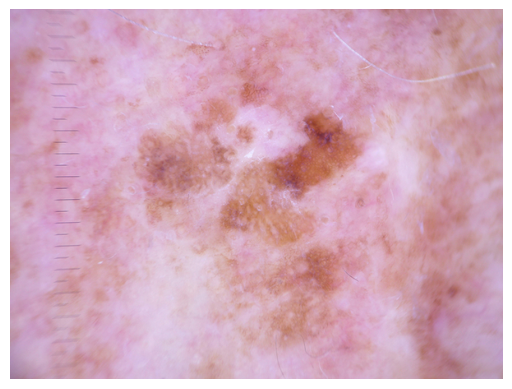

: 

In [ ]:
# from PIL import Image
# import io
# import matplotlib.pyplot as plt

# # Function to display an image from binary data
# def display_image(image_binary):
#     image = Image.open(io.BytesIO(image_binary))
#     plt.imshow(image)
#     plt.axis('off')  # Hide axis
#     plt.show()

# # Retrieve a single image from the DataFrame
# sample_image_binary = df['image_data'].iloc[0]  # Get the first image for example

# # Display the image
# display_image(sample_image_binary)


In [ ]:
# # Process images and retrieve the image arrays
# X_images = process_images(df)

In [ ]:
# # Process the images and extract the labels
# X_images = process_images(df)
# y_labels = df['dx'].values

KeyboardInterrupt: 

In [ ]:
# from sklearn.preprocessing import LabelEncoder, StandardScaler

# # Encode categorical variables
# df['sex'] = LabelEncoder().fit_transform(df['sex'])
# df['localization'] = LabelEncoder().fit_transform(df['localization'])
# df['dx'] = LabelEncoder().fit_transform(df['dx'])  # This will be the target variable

# # Normalize age
# scaler = StandardScaler()
# df['age'] = scaler.fit_transform(df[['age']])

# # Convert image binary data back into arrays and normalize pixel values
# def process_images(df):
#     images = []
#     for binary_data in df['image_data']:
#         image = Image.open(io.BytesIO(binary_data))
#         image = image.resize((224, 224))  # Resize to 224x224
#         image_array = np.array(image) / 255.0  # Normalize pixel values
#         images.append(image_array)
#     return np.array(images)

# X_images = process_images(df)
# y_labels = df['dx'].values


NameError: name 'Image' is not defined